## 학습 부진 학생 예측 모델 by Logistic Regression

In [627]:
# Library Import
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

# visualizing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.0)
import plotly.offline as py
py.init_notebook_mode(connected=True)
%matplotlib inline

### 데이터 호출 및 병합

In [628]:
# load data
train = pd.read_csv('전처리완료/train.csv', encoding='cp949')
train.drop(['Unnamed: 0'], axis=1, inplace=True)
test = pd.read_csv('전처리완료/test.csv', encoding='cp949')
test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [629]:
# 변수 의미

# USER_ID : 학번
# GEN_FG : 성별 (남자/여자)
# LOC_FG : 국적 (국내/해외)
# GRADE : 학년 (1,2,3,4,5,6학년)
# FLD_FG : 계열 (인문/사회/자연과학/공학/예체능)
# CONNECT_RAT : 평균 접속 비율 (해당 학기에 접속한 총 횟수 / 총수업횟수로 나눈 값)
# AVG_STUDY_TIME : 평균 수강 시간 (해당 학기에 수강한 모든 수업의 수강시간을 더한 후, (수업횟수*학점 수) 로 나눈 값)
# AVG_WEB_STUDY_TIME : 평균 웹 수강 시간 (AVG_STUDY_TIME 중 웹으로 접속해 수강한 시간)
# AVG_MOBILE_STUDY_TIME : 평균 모바일 수강 시간 (AVG_STUDY_TIME 중 모바일로 접속해 수강한 시간)
# ABSENT_RAT : 결석 비율
# AVG_ECLASS_RAT : 평균 이클래스 접속 비율
# ENTR_FG : 입학구분 (수시/정시/편입/외국인/재외국민/약학대학/추가)
# RE_ENTR_YN : 재입학 여부(Y/N)
# ACADEMIC_PROB_CNT : 학사경고횟수
# AVG_SCORE : 평균학점

In [630]:
# 변수 제거 : 분석해보면 다중공선성이 높게 나와서 사용할 수 없음. 이상치 때문에 데이터 제거되는것을 방지하기 위해 미리 drop함.
# train.drop(['AVG_WEB_STUDY_TIME', 'ABSENT_RAT'], axis=1, inplace=True)
# test.drop(['AVG_WEB_STUDY_TIME', 'ABSENT_RAT'], axis=1, inplace=True)

In [631]:
# 계열 3개로 줄이기(인문사회/자연공학/예체능)
train['FLD_FG'].replace('인문', '인문사회', inplace=True)
train['FLD_FG'].replace('사회', '인문사회', inplace=True)
train['FLD_FG'].replace('자연과학', '자연공학', inplace=True)
train['FLD_FG'].replace('공학', '자연공학', inplace=True)

test['FLD_FG'].replace('인문', '인문사회', inplace=True)
test['FLD_FG'].replace('사회', '인문사회', inplace=True)
test['FLD_FG'].replace('자연과학', '자연공학', inplace=True)
test['FLD_FG'].replace('공학', '자연공학', inplace=True)

In [632]:
# 외국인, 재외국민 합치기
train['ENTR_FG'].replace('외국인', '외국인및재외국민', inplace=True)
train['ENTR_FG'].replace('재외국민', '외국인및재외국민', inplace=True)

test['ENTR_FG'].replace('외국인', '외국인및재외국민', inplace=True)
test['ENTR_FG'].replace('재외국민', '외국인및재외국민', inplace=True)

# 편입, 약대 합치기
train['ENTR_FG'].replace('약학대학', '편입', inplace=True)
test['ENTR_FG'].replace('약학대학', '편입', inplace=True)

In [633]:
# 타겟값 정의 : 평균평점 1.75 미만인 학생을 학습 부진 학생으로 정의한다.
train.insert(12, 'TARGET', '')
for i in range(len(train)):
    if train['AVG_SCORE'].iloc[i] >= 1.75:
        train['TARGET'].iloc[i] = 0
    else:
        train['TARGET'].iloc[i] = 1

In [634]:
train.drop(['AVG_SCORE'], axis=1, inplace=True)

In [635]:
# 클래스 비율 확인
(train['TARGET'].value_counts() / len(train))*100

0    97.236202
1     2.763798
Name: TARGET, dtype: float64

In [636]:
# 학년을 수치형으로
for i in tqdm(range(len(train))):
    train['GRADE'].iloc[i] = train['GRADE'].iloc[i].replace('학년', '')

for i in tqdm(range(len(test))):
    test['GRADE'].iloc[i] = test['GRADE'].iloc[i].replace('학년', '')

100%|██████████| 11406/11406 [00:01<00:00, 6830.77it/s]


In [637]:
# 데이터타입 변경
train.loc[:, ['GRADE']] = train.loc[:, ['GRADE']].astype('int')
train.loc[:, ['USER_ID']] = train.loc[:, ['USER_ID']].astype('str')
train.loc[:, ['TARGET']] = train.loc[:, ['TARGET']].astype('int')

test.loc[:, ['GRADE']] = test.loc[:, ['GRADE']].astype('int')
test.loc[:, ['USER_ID']] = test.loc[:, ['USER_ID']].astype('str')

### 스케일링

In [638]:
# 수치형 컬럼
num_cols = ['GRADE', 'ACADEMIC_PROB_CNT', 'CONNECT_RAT', 'AVG_STUDY_TIME', 'AVG_MOBILE_STUDY_TIME', 'AVG_ECLASS_RAT', 'AVG_WEB_STUDY_TIME', 'ABSENT_RAT']

In [639]:
# train set skewness 확인
for col in num_cols:
    print(col, train[col].skew())

GRADE -0.3552168687635059
ACADEMIC_PROB_CNT 5.260090543970552
CONNECT_RAT 0.20167053897220774
AVG_STUDY_TIME 1.2588148371315373
AVG_MOBILE_STUDY_TIME 3.346306653701093
AVG_ECLASS_RAT 2.616121780487374
AVG_WEB_STUDY_TIME 1.277031535933222
ABSENT_RAT -0.2027120451444546


In [640]:
# test set skewness 확인
for col in num_cols:
    print(col, test[col].skew())

GRADE -0.1184970046990551
ACADEMIC_PROB_CNT 5.291483263701362
CONNECT_RAT -2.509811518161598
AVG_STUDY_TIME 0.27973398417780365
AVG_MOBILE_STUDY_TIME 2.3621827245647444
AVG_ECLASS_RAT 2.1931923264375355
AVG_WEB_STUDY_TIME 0.18946282948987922
ABSENT_RAT 2.513917066137304


In [641]:
# 로그변환
sk_cols = ['AVG_ECLASS_RAT', 'ACADEMIC_PROB_CNT', 'AVG_MOBILE_STUDY_TIME']
for col in sk_cols:
    train[col] = np.log1p(train[col])

for col in sk_cols:
    test[col] = np.log1p(test[col])

In [642]:
# 로그변환하지 않은 컬럼은 Standard Scaling 적용
from sklearn.preprocessing import StandardScaler
sc_cols = ['GRADE', 'CONNECT_RAT', 'AVG_STUDY_TIME', 'AVG_WEB_STUDY_TIME', 'ABSENT_RAT']
scaler = StandardScaler()
for col in sc_cols:
    train[col] = scaler.fit_transform(train[[col]])
    test[col] = scaler.transform(test[[col]])

In [643]:
# 데이터 이상치 탐색
def get_outlier(df=None, column=None, weight=1.5):

    fraud = df[df['TARGET']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [647]:
# 수치형 데이터의 이상치 제거
for col in num_cols:
    outlier_index = get_outlier(df=train, column=col, weight=1.5)
    print(col, ':', outlier_index)
    train.drop(outlier_index, axis=0, inplace=True)

GRADE : Int64Index([], dtype='int64')
ACADEMIC_PROB_CNT : Int64Index([], dtype='int64')
CONNECT_RAT : Int64Index([], dtype='int64')
AVG_STUDY_TIME : Int64Index([], dtype='int64')
AVG_MOBILE_STUDY_TIME : Int64Index([], dtype='int64')
AVG_ECLASS_RAT : Int64Index([], dtype='int64')
AVG_WEB_STUDY_TIME : Int64Index([], dtype='int64')
ABSENT_RAT : Int64Index([], dtype='int64')


In [645]:
# 이상치 없을때까지 제거
stop
stop

NameError: name 'stop' is not defined

In [648]:
train.reset_index(drop=True, inplace=True)

In [649]:
len(train)

11690

### 다중공선성 확인

In [ ]:
# modeling
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [650]:
# 범주형 변수 인코딩
cat_cols = ['GEN_FG', 'FLD_FG', 'LOC_FG', 'ENTR_FG', 'RE_ENTR_YN']
train_dummies = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test_dummies = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [651]:
# VIF
model = smf.ols('TARGET ~ GRADE + ACADEMIC_PROB_CNT + CONNECT_RAT + AVG_STUDY_TIME + AVG_MOBILE_STUDY_TIME + AVG_ECLASS_RAT +  GEN_FG_여자 + FLD_FG_인문사회 + FLD_FG_자연공학 +  LOC_FG_해외 + ENTR_FG_외국인및재외국민 + ENTR_FG_정시 + ENTR_FG_추가 + ENTR_FG_편입 + RE_ENTR_YN_Y', data=train_dummies)
pd.DataFrame({'Feature': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept').sort_values(by=['VIF'], ascending=False)

,Feature,VIF
8,FLD_FG_자연공학,4.415024
7,FLD_FG_인문사회,4.276567
9,LOC_FG_해외,2.639493
10,ENTR_FG_외국인및재외국민,2.630502
3,AVG_STUDY_TIME,1.245205
4,AVG_MOBILE_STUDY_TIME,1.221270
1,ACADEMIC_PROB_CNT,1.215602
13,ENTR_FG_편입,1.194503
6,GEN_FG_여자,1.143759
11,ENTR_FG_정시,1.138134


### 모델링: 로지스틱

In [652]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

In [849]:
train_new = train_dummies.drop(['ABSENT_RAT', 'AVG_WEB_STUDY_TIME'], axis=1)
test_new = test_dummies.drop(['ABSENT_RAT', 'AVG_WEB_STUDY_TIME'], axis=1)

In [850]:
# train set: 독립변수, 종속변수 분리
X = train_new.drop(['USER_ID', 'TARGET'],axis=1)
y = train_new['TARGET']

In [851]:
# p-value 확인
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.Logit(y, X)
results = model.fit()

print( results.summary() )

Optimization terminated successfully.
         Current function value: 0.088559
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:                11690
Model:                          Logit   Df Residuals:                    11674
Method:                           MLE   Df Model:                           15
Date:                Fri, 24 Dec 2021   Pseudo R-squ.:                  0.2399
Time:                        16:42:49   Log-Likelihood:                -1035.3
converged:                       True   LL-Null:                       -1362.1
Covariance Type:            nonrobust   LLR p-value:                1.407e-129
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.9491      0.335     -8.811      0.000      -3.605      -2.

In [852]:
X.drop(['const'], axis=1, inplace=True)

In [853]:
# train set, valid set으로 split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=60, stratify=y)

In [854]:
print('학습 세트 레이블 값 분포')
print(y_train.value_counts())
print('\n 검증 세트 레이블 값 분포 비율')
print(y_valid.value_counts())

학습 세트 레이블 값 분포
0    7979
1     204
Name: TARGET, dtype: int64

 검증 세트 레이블 값 분포 비율
0    3420
1      87
Name: TARGET, dtype: int64


### 모델 - Logistic Regression

In [855]:
lgr = LogisticRegression()

In [856]:
# Grid Search
from sklearn.model_selection import GridSearchCV

params={'penalty':['l2', 'l1'],
        'C':[i for i in range(1, 11)]}

# 상세 조정한 kfold 객체 생성
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state=20)

grid = GridSearchCV(lgr, param_grid=params, scoring='f1', cv=skf, n_jobs=-1)
grid.fit(X_train, y_train)

print('최적 하이퍼 파라미터:{0}, 최적 f1-score :{1:.4f}'.format(grid.best_params_, grid.best_score_))

최적 하이퍼 파라미터:{'C': 6, 'penalty': 'l2'}, 최적 f1-score :0.1097


In [858]:
# Logistic Regression
lgr = LogisticRegression(C=6, penalty='l2')
lgr.fit(X_train, y_train)

LogisticRegression(C=6)

In [859]:
# Prediction
lgr_pred = lgr.predict(X_valid)
lgr_pred_proba = lgr.predict_proba(X_valid)[:, 1]

In [860]:
# Confusion Matrix
def get_clf_eval(y_valid, pred, lgr_pred_proba):
    confusion = confusion_matrix(y_valid, pred)
    accuracy = accuracy_score(y_valid, pred)
    precision = precision_score(y_valid, pred)
    recall = recall_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    roc_auc = roc_auc_score(y_valid, lgr_pred_proba)
    print('오차행렬')
    print(confusion)
    print('accuracy:{0:.4f}, precision:{1:.4f}, recall:{2:.4f}, f1_score:{3:.4f}, roc_auc:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [861]:
# Validation
get_clf_eval(y_valid, lgr_pred, lgr_pred_proba)

오차행렬
[[3413    7]
 [  79    8]]
accuracy:0.9755, precision:0.5333, recall:0.0920, f1_score:0.1569, roc_auc:0.8428


In [862]:
# beta, exp(beta) 확인
column_name = ["const"] + X_train.columns.tolist()
beta = np.concatenate([lgr.intercept_, lgr.coef_.reshape(-1)]).round(2)
odds = np.exp(beta).round(2)

beta_analysis = pd.DataFrame(np.c_[beta, odds], index=column_name, columns=['beta', 'exp(beta)'])
beta_analysis.drop('const', inplace=True)

In [863]:
beta_analysis.sort_values(by = 'beta', ascending=False)

,beta,exp(beta)
ACADEMIC_PROB_CNT,2.36,10.59
ENTR_FG_추가,2.07,7.92
LOC_FG_해외,0.99,2.69
ENTR_FG_편입,0.26,1.30
AVG_MOBILE_STUDY_TIME,0.19,1.21
ENTR_FG_외국인및재외국민,0.10,1.11
ENTR_FG_정시,0.09,1.09
CONNECT_RAT,-0.14,0.87
FLD_FG_자연공학,-0.17,0.84
GEN_FG_여자,-0.36,0.70


### Recall - Precision Curve

In [864]:
def precision_recall_curve_plot(y_valid , pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_valid, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

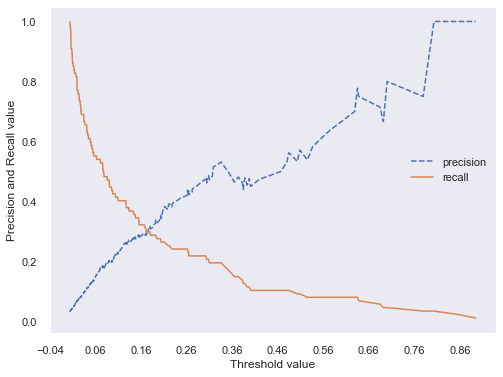

In [865]:
# precision과 recall 커브 그려서 임계값 확인
precision_recall_curve_plot(y_valid, lgr_pred_proba)

In [884]:
# Threshold 값 조정
from sklearn.preprocessing import Binarizer
custom_threshold = 0.1263
pred_proba_1 = lgr_pred_proba.reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_valid, custom_predict, lgr_pred_proba)

오차행렬
[[3322   98]
 [  52   35]]
accuracy:0.9572, precision:0.2632, recall:0.4023, f1_score:0.3182, roc_auc:0.8428


In [885]:
len(train)

11690

### 테스트셋 적용

In [886]:
result = pd.DataFrame(columns=['USER_ID', 'TARGET'])

In [887]:
X_test = test_new.drop(['USER_ID'], axis=1)
y_test = test_new['USER_ID']

In [888]:
# 확률 예측
ori_pred_proba = lgr.predict_proba(X_test)[:, 1]

In [889]:
# threshold에 맞게 조정
pred_proba_test = ori_pred_proba.reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_test)
custom_predict_test = binarizer.transform(pred_proba_test)

In [890]:
result['USER_ID'] = y_test
result['TARGET'] = custom_predict_test

In [891]:
# 데이터타입 변경
result['TARGET'] = result['TARGET'].astype(int)

In [892]:
result['TARGET'].value_counts() # 202명 예측

0    11204
1      202
Name: TARGET, dtype: int64

In [893]:
# 학적과 연계
user = pd.read_csv('ORACLE 및 VC 추출데이터/학적(00학번~21학번).csv', encoding='cp949')

In [894]:
user.rename(columns={'STD_NO':'USER_ID'}, inplace=True)
user['USER_ID'] = user['USER_ID'].astype(str)

In [895]:
result_finl = pd.merge(result, user[['USER_ID', 'KOR_NM', 'GEN_FG', 'SHYR_CD', 'COLG_NM', 'SUST_NM', 'MJ_NM', 'NATI_NM']], on='USER_ID', how='left')

In [896]:
# 학습 부진 학생 목록
std_lst = result_finl.loc[result_finl['TARGET'] == 1]

In [897]:
std_lst.drop(['TARGET'], axis=1, inplace=True)

In [898]:
std_lst

,USER_ID,KOR_NM,GEN_FG,SHYR_CD,COLG_NM,SUST_NM,MJ_NM,NATI_NM
0,2001110176,정의훈,남자,4학년,문과대학,철학과,NaN,대한민국
3,2005113136,김덕규,남자,4학년,바이오시스템대학,바이오환경과학과,NaN,대한민국
7,2007113120,전효경,여자,4학년,예술대학,문예창작학과,NaN,대한민국
8,2008110487,김경민,남자,4학년,이과대학,화학과,NaN,대한민국
11,2008113006,전성수,남자,4학년,영상미디어대학,광고홍보학과,NaN,대한민국
...,...,...,...,...,...,...,...,...
11302,2021112956,문준호,남자,1학년,예술대학,스포츠문화학과,NaN,대한민국
11318,2021113132,양승경,여자,1학년,공과대학,전자전기공학부,NaN,대한민국
11319,2021113138,이진용,남자,1학년,공과대학,컴퓨터정보통신공학부,컴퓨터공학전공,대한민국
11322,2021113142,박동현,남자,1학년,공과대학,건설환경공학과,NaN,대한민국


In [899]:
# 저장
# std_lst.to_csv('2021학년도_2학기_학습부진학생_예측명단(1224_2).csv', index=False, encoding='cp949')